In [15]:
# ==========================================
# Agglomerative Hierarchical Clustering Model
# ==========================================

In [16]:
#1. Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from scipy.cluster.hierarchy import dendrogram, linkage

In [17]:
#2.  Load dataset
data = pd.read_csv("../Data/06_filtered_customers_enhanced.csv")  # Update if path differs
print("Dataset Shape:", data.shape)
display(data.head())

# Check missing values and datatypes
print("\nMissing values per column:")
print(data.isnull().sum())
print("\nData types:")
print(data.dtypes)

Dataset Shape: (4256, 8)


,customer_id,R,F,M,R_scaled,F_scaled,M_scaled,Status
0,12346,325,12,400.94,0.591999,0.443501,-0.273951,Keep
1,12347,2,8,4585.32,-0.949974,0.134057,0.379317,Keep
2,12348,75,5,1072.23,-0.601479,-0.098027,-0.169149,Keep
3,12349,18,4,4388.34,-0.873592,-0.175388,0.348565,Keep
4,12352,36,10,2849.84,-0.787661,0.288779,0.108373,Keep



Missing values per column:
customer_id    0
R              0
F              0
M              0
R_scaled       0
F_scaled       0
M_scaled       0
Status         0
dtype: int64

Data types:
customer_id      int64
R                int64
F                int64
M              float64
R_scaled       float64
F_scaled       float64
M_scaled       float64
Status          object
dtype: object


In [18]:
#3. Data Preprocessing
# Select only numeric columns
data_numeric = data.select_dtypes(include=[np.number])

# Handle missing values
data_numeric = data_numeric.dropna()

# Feature scaling
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data_numeric)

print("Scaled data shape:", scaled_data.shape)


Scaled data shape: (4256, 7)


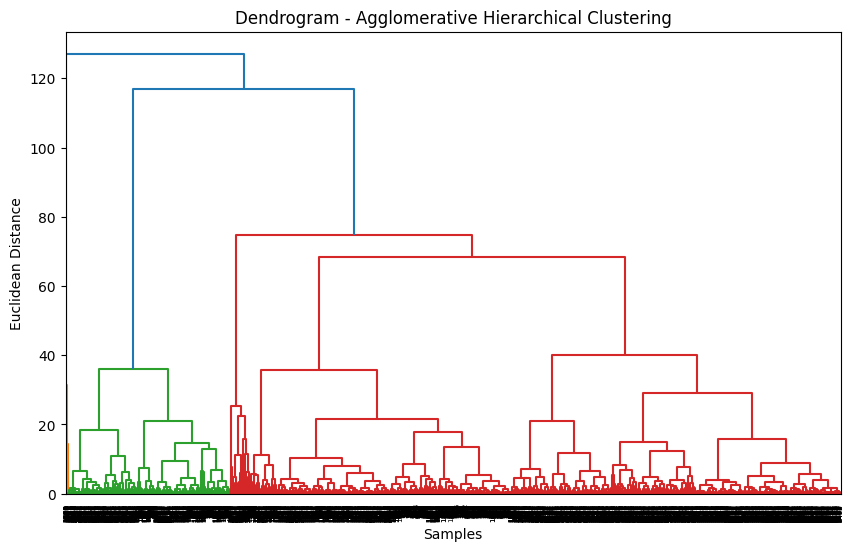

In [19]:
#4. Dendrogram to Choose Clusters
# Create dendrogram
plt.figure(figsize=(10, 6))
linkage_matrix = linkage(scaled_data, method='ward')
dendrogram(linkage_matrix)
plt.title("Dendrogram - Agglomerative Hierarchical Clustering")
plt.xlabel("Samples")
plt.ylabel("Euclidean Distance")
plt.savefig('../results/eda_visualization/agglomerative_dendrogram.png')
plt.show()

In [20]:
#5. Model Training – Three Variations

In [21]:
# Model 1 – Ward Linkage – Variance Minimization
model1 = AgglomerativeClustering(n_clusters=3, linkage='ward')
labels1 = model1.fit_predict(scaled_data)
data['Cluster_Ward'] = labels1

In [22]:
# Model 2 – Complete Linkage – Maximum Distance Criterion
model2 = AgglomerativeClustering(n_clusters=3, linkage='complete')
labels2 = model2.fit_predict(scaled_data)
data['Cluster_Complete'] = labels2

In [23]:
# Model 3 – Average Linkage – Balanced Cluster Formation
model3 = AgglomerativeClustering(n_clusters=3, linkage='average')
labels3 = model3.fit_predict(scaled_data)
data['Cluster_Average'] = labels3

In [24]:
print("Clustering complete.")

Clustering complete.


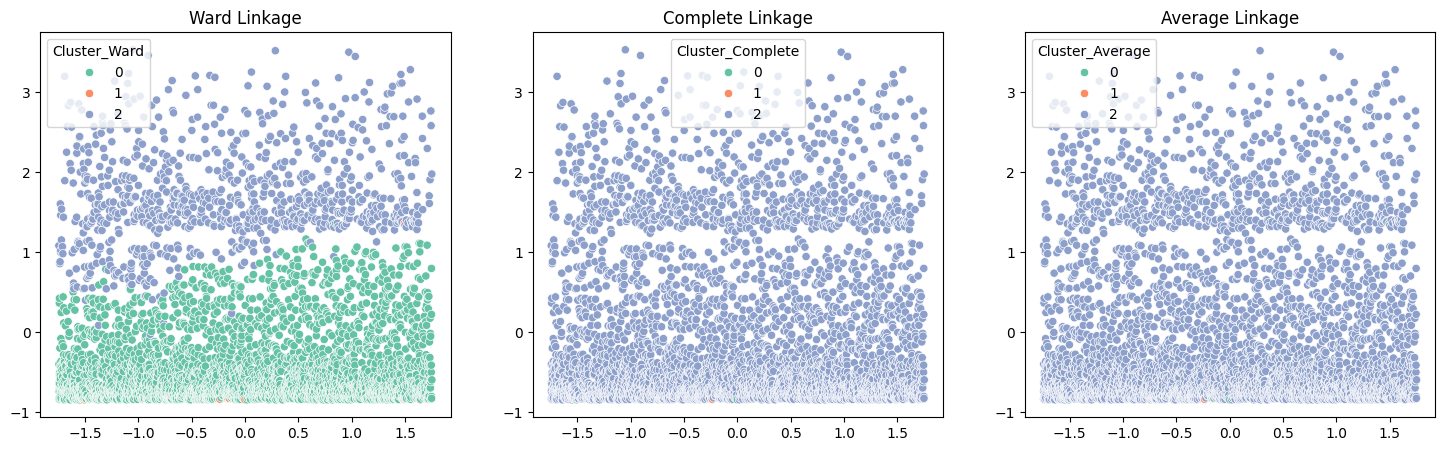

In [25]:
#6. Visualize the Clusters
# Visualize results for each model using first 2 scaled features
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

sns.scatterplot(x=scaled_data[:, 0], y=scaled_data[:, 1], hue=data['Cluster_Ward'], palette='Set2', ax=axes[0])
axes[0].set_title("Ward Linkage")

sns.scatterplot(x=scaled_data[:, 0], y=scaled_data[:, 1], hue=data['Cluster_Complete'], palette='Set2', ax=axes[1])
axes[1].set_title("Complete Linkage")

sns.scatterplot(x=scaled_data[:, 0], y=scaled_data[:, 1], hue=data['Cluster_Average'], palette='Set2', ax=axes[2])
axes[2].set_title("Average Linkage")

plt.savefig('../results/eda_visualization/agglomerative_clusters_comparison.png')
plt.show()

In [26]:
#7. Cluster Statistics and Comparison
# Group and summarize only numeric columns
for name in ['Cluster_Ward', 'Cluster_Complete', 'Cluster_Average']:
    print(f"\n===== {name} Summary =====")
    cluster_summary = data.groupby(name)[data.select_dtypes(include=[np.number]).columns].mean()
    cluster_counts = data[name].value_counts().sort_index()
    print("Cluster Counts:\n", cluster_counts)
    print("\nCluster Means:\n", cluster_summary)
    print("\n--------------------------------------\n")



===== Cluster_Ward Summary =====
Cluster Counts:
 Cluster_Ward
0    3350
1      14
2     892
Name: count, dtype: int64

Cluster Means:
                customer_id           R           F             M  R_scaled  \
Cluster_Ward                                                                 
0             15369.525373   66.118507    8.768060   2950.957085 -0.643878   
1             15273.142857   28.785714  182.285714  92637.444286 -0.822102   
2             15088.096413  430.230942    3.707399   1135.632244  1.094362   

               F_scaled   M_scaled  Cluster_Ward  Cluster_Complete  \
Cluster_Ward                                                         
0              0.193474   0.124159           0.0          2.000000   
1             13.616982  14.126079           1.0          0.928571   
2             -0.198024  -0.159250           2.0          2.000000   

              Cluster_Average  
Cluster_Ward                   
0                    2.000000  
1                    0.35

In [27]:
#8. Comprehensive Clustering Evaluation
# Evaluate quality of each model with multiple metrics
print("="*60)
print("COMPREHENSIVE CLUSTERING EVALUATION")
print("="*60)

results = []

for name, labels in [
    ('Ward', data['Cluster_Ward']),
    ('Complete', data['Cluster_Complete']),
    ('Average', data['Cluster_Average'])
]:
    # Calculate all clustering metrics
    silhouette = silhouette_score(scaled_data, labels)
    davies_bouldin = davies_bouldin_score(scaled_data, labels)
    calinski_harabasz = calinski_harabasz_score(scaled_data, labels)
    
    # Store results
    results.append({
        'Linkage': name,
        'Silhouette_Score': silhouette,
        'Davies_Bouldin_Index': davies_bouldin,
        'Calinski_Harabasz_Score': calinski_harabasz
    })
    
    print(f"\n{name} Linkage Results:")
    print(f"  • Silhouette Score:        {silhouette:.4f} (Higher is better)")
    print(f"  • Davies-Bouldin Index:    {davies_bouldin:.4f} (Lower is better)")
    print(f"  • Calinski-Harabasz Score: {calinski_harabasz:.2f} (Higher is better)")

# Create results DataFrame for easy comparison
results_df = pd.DataFrame(results)
print("\n" + "="*60)
print("SUMMARY TABLE:")
print("="*60)
print(results_df.round(4))

# Identify best performing model for each metric
print("\n" + "="*60)
print("BEST PERFORMING MODELS:")
print("="*60)
best_silhouette = results_df.loc[results_df['Silhouette_Score'].idxmax(), 'Linkage']
best_davies_bouldin = results_df.loc[results_df['Davies_Bouldin_Index'].idxmin(), 'Linkage']
best_calinski = results_df.loc[results_df['Calinski_Harabasz_Score'].idxmax(), 'Linkage']

print(f"• Best Silhouette Score:        {best_silhouette}")
print(f"• Best Davies-Bouldin Index:    {best_davies_bouldin}")
print(f"• Best Calinski-Harabasz Score: {best_calinski}")
print("="*60)

COMPREHENSIVE CLUSTERING EVALUATION

Ward Linkage Results:
  • Silhouette Score:        0.4390 (Higher is better)
  • Davies-Bouldin Index:    0.7548 (Lower is better)
  • Calinski-Harabasz Score: 2132.63 (Higher is better)

Complete Linkage Results:
  • Silhouette Score:        0.9027 (Higher is better)
  • Davies-Bouldin Index:    0.3398 (Lower is better)
  • Calinski-Harabasz Score: 866.84 (Higher is better)

Average Linkage Results:
  • Silhouette Score:        0.8879 (Higher is better)
  • Davies-Bouldin Index:    0.3717 (Lower is better)
  • Calinski-Harabasz Score: 982.78 (Higher is better)

SUMMARY TABLE:
    Linkage  Silhouette_Score  Davies_Bouldin_Index  Calinski_Harabasz_Score
0      Ward            0.4390                0.7548                2132.6267
1  Complete            0.9027                0.3398                 866.8407
2   Average            0.8879                0.3717                 982.7830

BEST PERFORMING MODELS:
• Best Silhouette Score:        Complete
• Bes

In [28]:
#9. Save Results
data.to_csv("../results/outputs/AgglomerativeClustering_Results.csv", index=False)
print("Clustered results saved as ../results/outputs/AgglomerativeClustering_Results.csv")

Clustered results saved as ../results/outputs/AgglomerativeClustering_Results.csv
